In [1]:
import pandas as pd
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import os
from os.path import join as pjoin
import numpy as np
import pandas as pd
from time import time, sleep, strftime, localtime
from datetime import datetime

%reload_ext autoreload
%autoreload 1

pd.set_option('display.max_rows', 800)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 100)
pd.set_option('display.max_colwidth', 500)

display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

In [66]:
import re, string
import requests
from bs4 import BeautifulSoup
from itertools import groupby
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer

from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.decomposition import LatentDirichletAllocation

from Utils.UtilsViz import *
from Utils.DataUtils import *

In [3]:
data_path = "./data"
os.listdir(data_path)
train_set = pd.read_csv(pjoin(data_path, 'train.csv'))
test_set = pd.read_csv(pjoin(data_path, 'test.csv'))

In [4]:
train_set_ori = train_set.copy()

In [5]:
display(
    train_set.shape,
    train_set.head()
)

(7613, 5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [6]:
analyse_nans(train_set)

,id,keyword,location,text,target
total,0,61,2533,0,0
percentage,0,0.8,33.3,0,0
idx_list,[],"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 7583, 7584, 7585, 7586, 7587, 7588, 7589, 7590, 7591, 7592, 7593, 7594, 7595, 7596, 7597, 7598, 7599, 7600, 7601, 7602, 7603, 7604, 7605, 7606, 7607, 7608, 7609, 7610, 7611, 7612]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 38, 41, 43, 44, 45, 47, 60, 75, 80, 82, 85, 90, 92, 99, 110, 112, 116, 122, 123, 130, 131, 132, 135, 140, 147, 152, 156, 159, 164, 171, 174, 177, 182, 185, 187, 190, 196, 198, 202, 205, 206, 213, 214, 215, 219, 220, 222, 224, 225, 229, 231, 234, 236, 238, 240, 244, 245, 246, 250, 253, 256, 257, 261, 262, 267, 268, 274, 275, 279, ...]",[],[]


Much cleaner than msot datasets, to be fair.

Class distributions

In [7]:
train_set["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

Fairly close. Can definitely work with this.

#  Text cleaning

1. Lowercase text
1. Remove special unrendered words
1. Remove hyperlinks
1. Remove non alphabets
1. remove stop words
1. Lemmatization

In [8]:
# Lowercase text
train_set["text"] = train_set["text"].apply(str.lower)

In [9]:
# Remove special unrendered words
# Example - & is represented as "&amp"
special_words = ["&amp;"]

def remove_specialwords(x):
    clean_str = [word for word in x.split(' ') if not any(spword in word for spword in special_words)]
    return ' '.join(clean_str)

train_set["text"] = train_set["text"].apply(remove_specialwords)

In [10]:
# Remove hyperlinks
def remove_urls(x):
    clean_str = [word for word in x.split(' ') if "http" not in word]
    return ' '.join(clean_str)

train_set["text"] = train_set["text"].apply(remove_urls)

In [11]:
# Remove non-alphabets
train_set["text"] = train_set["text"].apply(lambda x: re.sub('[^a-zA-Z ]', '', x))

In [12]:
# Remove stop words
stop_words = text.ENGLISH_STOP_WORDS

def remove_stopwords(x):
    clean_str = [word for word in x.split(' ') if word not in stop_words]
    return ' '.join(clean_str)

train_set['text'] = train_set['text'].apply(remove_stopwords)

In [13]:
# Lemmatize the words
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize_words(x):
    clean_str = [wordnet_lemmatizer.lemmatize(word, pos="v") for word in x.split(' ')]
    return ' '.join(clean_str)

train_set['text'] = train_set['text'].apply(lemmatize_words)

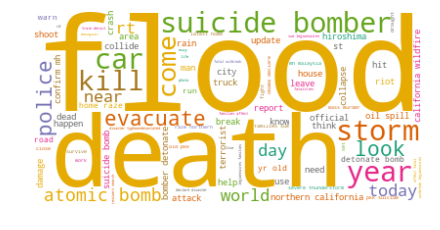

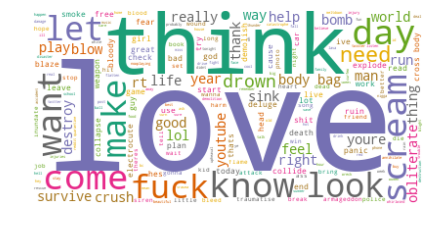

In [25]:
# Reset the output dimensions
wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

def plot_wordcloud(text, wc, figsize=[7,7], title=""):
    plt.rcParams['figure.figsize'] = figsize
    wc.generate(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()
    
    
q1 = "target==1"
t1 = ' '.join(train_set.query(q1)["text"].values)
plot_wordcloud(t1, wc)

q2 = "target==0"
t2 = ' '.join(train_set.query(q2)["text"].values)
plot_wordcloud(t2, wc)

We need to remove additional words that are polluting the wordcloud

# Find the most frequently occuring words for each 

We are going to create a document-term matrix using CountVectorizer, and exclude common English stop words

In [15]:
cv_0 = CountVectorizer(stop_words=stop_words)
train_cv_0 = cv_0.fit_transform(train_set.query("target==0")["text"])
train_cv_0_dtm = pd.DataFrame(train_cv_0.toarray(), columns=cv_0.get_feature_names())
train_cv_0_dtm.index = train_set.query("target==0")["id"]
train_cv_0_dtm.head()

,aa,aaaa,aaceorg,aannnnd,aar,aaronthefm,ab,aba,abandon,abandonedpics,abbandoned,abbott,abbruchsimulator,abc,abceyewitness,abcnews,abe,aberdeen,aberdeenfanpage,aberdeenfc,abetter,ability,abject,ablaze,able,abomination,abortion,abortions,abovewould,abrancaballero,absolute,absolutely,absolutsumya,abstract,absurdly,abubaraa,abuse,abysmaljoiner,ac,acaciapenn,academia,acarewornheart,acc,accept,access,accident,accidentally,accidentalprophecy,accidently,accidents,...,yum,yumiko,yunita,yup,yuppies,yuvi,yyeso,zabadani,zacb,zach,zachlowenba,zachzaidman,zaire,zakbagans,zamtriossu,zar,zarharzar,zarry,zayn,zaynmalik,zenandemcfen,zenit,zeno,zepp,zero,zhejiang,zhenghxn,zicac,zimbabwe,zimmerman,zip,ziphimup,zippednews,zipper,zippoline,zmne,zodiac,zombie,zombiefunrun,zombies,zone,zonesthank,zonewolf,zoom,zouma,zrnf,zss,zumiez,zxathetis,zzzz
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [16]:
cv_1 = CountVectorizer(stop_words=stop_words)
train_cv_1 = cv_1.fit_transform(train_set.query("target==1")["text"])
train_cv_1_dtm = pd.DataFrame(train_cv_1.toarray(), columns=cv_1.get_feature_names())
train_cv_1_dtm.index = train_set.query("target==1")["id"]
train_cv_1_dtm.head()

,aa,aaaaaaallll,aal,aan,aashiqui,aba,abandon,abbswinston,abbyairshow,abc,abcchicago,abcnews,abcnorio,abcs,abe,aberystwythshrewsbury,abes,abha,abia,ability,ablaze,able,ableg,abninfvet,aboard,abomb,abombed,abortion,abouts,abs,absence,absolute,absolutely,abstorm,absurd,abubaraa,abuse,ac,acc,accept,accepte,accident,accidentally,accidents,accidentwho,accionempresa,accord,account,accuracy,accuse,...,youd,yougov,youll,young,younger,youngheroesid,youre,yourstate,youth,youtube,youve,ypg,ypres,yr,yrs,yug,yugvani,yyc,yycfringe,yycstorm,yycwalks,yycweather,yygb,yyj,yzf,zaatari,zaibatsunews,zakbagans,zakuun,zaman,zayn,zaynmaiikist,zeal,zehrs,zergele,zimmer,zimpapersviews,zionism,zionist,zionists,zippednews,ziuw,zkesk,zojadelin,zomatoaus,zombie,zone,zotar,zourryart,zurich
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
train_cv_0_dtm_t = train_cv_0_dtm.transpose()
train_cv_1_dtm_t = train_cv_1_dtm.transpose()

What are the most common words?

In [18]:
def get_top_words(df):
    df["total_freq"] = df.sum(axis=1)
    return df[["total_freq"]].sort_values(by="total_freq", ascending=False)

t0_common = get_top_words(train_cv_0_dtm_t)
t1_common = get_top_words(train_cv_1_dtm_t)

In [19]:
t0_common.head(30)

id,total_freq
like,292
im,245
just,232
new,170
dont,152
body,117
bag,110
love,109
come,109
say,106


In [20]:
t1_common.head(30)

id,total_freq
bomb,180
kill,159
news,136
flood,120
disaster,116
crash,111
california,111
suicide,110
train,109
people,106


What words occur in both in the top 50?

In [21]:
common_words = find_common_elems([list(t0_common.head(50).index), list(t1_common.head(50).index)])
common_words

['time',
 'burn',
 'im',
 'just',
 'news',
 'video',
 'people',
 'say',
 'dont',
 'emergency',
 'new',
 'build',
 'watch',
 'like']

Let's add these to the stop words

In [22]:
stop_words = stop_words.union(set(common_words))

Now we'll recreate our word clouds

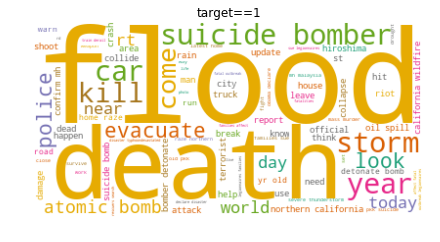

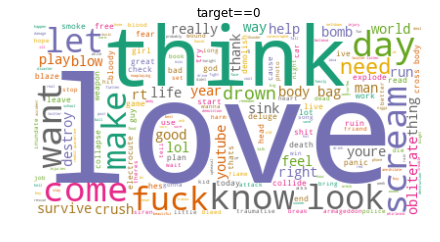

In [24]:
# Reset the output dimensions
wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

def plot_wordcloud(text, wc, figsize=[7,7], title=""):
    plt.rcParams['figure.figsize'] = figsize
    wc.generate(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()
    
    
q1 = "target==1"
t1 = ' '.join(train_set.query(q1)["text"].values)
plot_wordcloud(t1, wc, title=q1)

q2 = "target==0"
t2 = ' '.join(train_set.query(q2)["text"].values)
plot_wordcloud(t2, wc, title=q2)

Is there a sentiment polarity difference in the dataset?

In [29]:
sen_pol = lambda x: (np.round(TextBlob(x).sentiment.polarity,2), 
                     np.round(TextBlob(x).sentiment.subjectivity))
train_set["polarity_subjectivity"] = train_set["text"].apply(func=sen_pol)
train_set["polarity"] = train_set["polarity_subjectivity"].apply(lambda x: x[0])
train_set["subjectivity"] = train_set["polarity_subjectivity"].apply(lambda x: x[1])
train_set.drop("polarity_subjectivity", axis=1, inplace=True)
train_set.head()

,id,keyword,location,text,target,polarity,subjectivity
0,1,NaN,NaN,deeds reason earthquake allah forgive,1,0.0,0.0
1,4,NaN,NaN,forest near la ronge sask canada,1,0.1,0.0
2,5,NaN,NaN,residents ask shelter place notify officer evacuation shelter place order expect,1,0.0,0.0
3,6,NaN,NaN,people receive wildfires evacuation order california,1,0.0,0.0
4,7,NaN,NaN,just get send photo ruby alaska smoke wildfires pour school,1,0.0,0.0


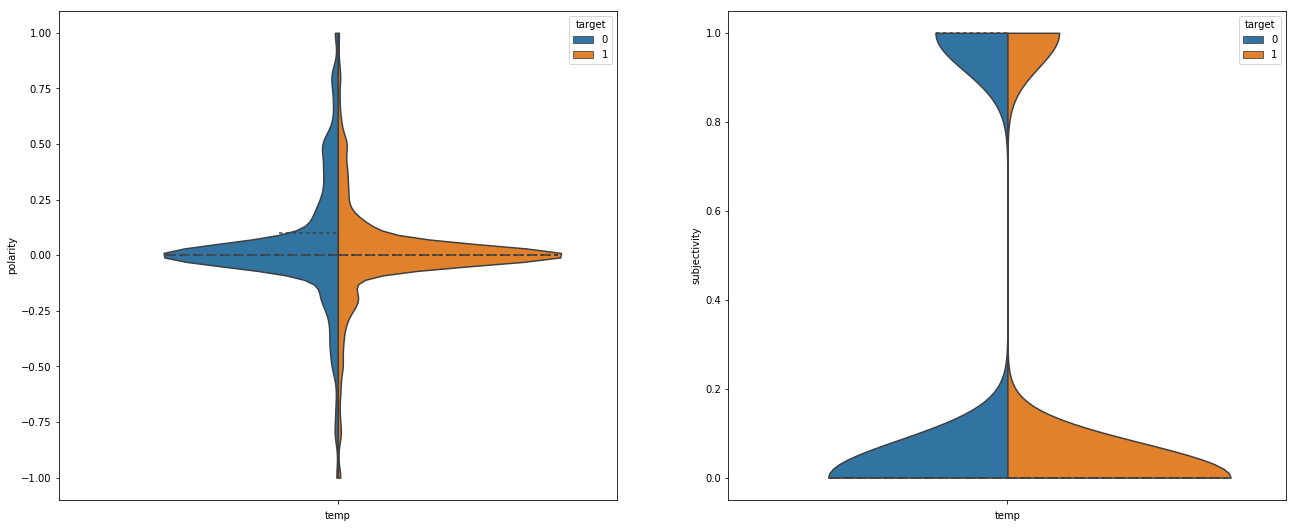

In [65]:
f, ax = plt.subplots(1,2,figsize=(22,9))
# Bug? https://stackoverflow.com/questions/33745746/split-violinplot-in-seaborn-with-hue-parameter
train_set["temp"] = ""
g = sns.violinplot(y="polarity", x="temp", hue="target", data=train_set, ax=ax[0], inner='quartile', cut=0, split=True)
g = sns.violinplot(y="subjectivity", x="temp", hue="target", data=train_set, ax=ax[1], inner='quartile', cut=0, split=True)

train_set.drop("temp", inplace=True, axis=1)

Polarities are predominantly 0, while subjectivities aren't really useful either.

What about LDA Topic modeling?

In [ ]:
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

def plot_lda(df, colname, num_topics=3, min_df=0.05, max_df=0.8, max_iter=100):
    # Make the vectorizer and vectorize the data
    
    # NOTE : Use previous count vectorized functions
    vectorizer = CountVectorizer(min_df=min_df,  # if a word exists in less than 10% documents, ignore them
                                 max_df=max_df,  # Avoid words that come in over 90% of all documents
                                 stop_words=stop_words, 
                                 lowercase=True)
    data_vectorized = vectorizer.fit_transform(df[colname])

    # Build a Latent Dirichlet Allocation Model
    lda_model = LatentDirichletAllocation(n_components=num_topics, 
                                          max_iter=max_iter,
                                          learning_method='online')
    lda_Z = lda_model.fit_transform(data_vectorized)
    panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
    return panel

In [ ]:
# panel_0 = plot_lda(train_set.query("target==0"), colname="text", num_topics=2, min_df=0, max_iter=10)
# panel_1 = plot_lda(train_set.query("target==1"), colname="text", num_topics=2, min_df=0, max_iter=20)

LDA takes waay too long in my laptop. I'm going to not do it.

--------------

Predictive Modeling